In [1]:
from glob import glob

from PIL import Image


file_paths = []
ellipse_data = []

label_files = glob("../data/FDDB/labels/*.txt")

for filename in label_files:
    with open(filename) as f:
        if "ellipseList" not in filename:
            file_paths += [p.strip("\n") for p in f.readlines()]
        else:
            ellipse_data += [p.strip("\n") for p in f.readlines()]

ellipse_data

['2002/08/22/big/img_141',
 '3',
 '65.889900 39.720000 -1.530189 218.360000 87.018000  1',
 '36.191000 24.307100 -1.534162 44.015500 251.081100  1',
 '23.683200 16.536200 1.567965 114.823900 84.816900  1',
 '2002/07/22/big/img_303',
 '1',
 '121.929374 77.939847 -1.564435 129.035774 139.720938  1',
 '2002/08/09/big/img_393',
 '1',
 '90.893360 62.123815 1.552576 258.878029 100.794935  1',
 '2002/07/29/big/img_963',
 '1',
 '99.783883 64.582295 1.564343 194.932542 158.701581  1',
 '2002/08/02/big/img_1215',
 '1',
 '121.838378 81.652050 1.305782 162.970769 135.962662  1',
 '2002/08/19/big/img_674',
 '1',
 '48.805858 30.139747 -1.438966 125.868136 57.092219  1',
 '2002/08/12/big/img_690',
 '1',
 '109.428425 78.241559 1.455810 129.036913 243.826893  1',
 '2002/08/21/big/img_637',
 '1',
 '105.537600 60.064700 1.486130 122.453900 140.092500  1',
 '2002/08/21/big/img_841',
 '1',
 '85.395800 57.632700 -1.473779 374.838300 100.403100  1',
 '2002/08/24/big/img_71',
 '2',
 '75.828185 46.827454 1.511

In [2]:
import pandas as pd

In [3]:
pdf_file_paths = pd.DataFrame({"path": file_paths})
pdf_file_paths["path_idx"] = pdf_file_paths.index

pdf_ellipse_data = pd.DataFrame({"data": ellipse_data})
pdf_ellipse_data["data_idx"] = pdf_ellipse_data.index

In [4]:
pdf_file_data_mapping = pdf_file_paths.merge(
    pdf_ellipse_data, left_on="path", right_on="data", how="left"
)

In [5]:
ellipse_dict = {str(k): [] for k in pdf_file_paths["path"]}
ellipse_dict

{'2002/08/18/big/img_181': [],
 '2002/08/10/big/img_520': [],
 '2002/08/25/big/img_705': [],
 '2002/08/23/big/img_226': [],
 '2002/08/04/big/img_727': [],
 '2002/07/24/big/img_625': [],
 '2002/08/28/big/img_19157': [],
 '2002/08/23/big/img_586': [],
 '2002/07/31/big/img_232': [],
 '2003/01/13/big/img_240': [],
 '2003/01/14/big/img_321': [],
 '2003/01/15/big/img_533': [],
 '2002/07/23/big/img_480': [],
 '2002/07/24/big/img_371': [],
 '2002/08/21/big/img_702': [],
 '2002/08/31/big/img_17075': [],
 '2002/09/02/big/img_15278': [],
 '2002/07/29/big/img_246': [],
 '2003/01/15/big/img_829': [],
 '2003/01/15/big/img_1213': [],
 '2003/01/16/big/img_441': [],
 '2002/08/14/big/img_921': [],
 '2002/07/23/big/img_425': [],
 '2002/08/15/big/img_296': [],
 '2002/07/19/big/img_135': [],
 '2002/07/26/big/img_402': [],
 '2003/01/17/big/img_88': [],
 '2002/08/20/big/img_872': [],
 '2002/08/13/big/img_1110': [],
 '2003/01/16/big/img_1040': [],
 '2002/07/23/big/img_9': [],
 '2002/08/13/big/img_700': [],
 '

In [6]:
for i, r in pdf_file_data_mapping.iterrows():
    data_idx = r["data_idx"]
    num_ellipses = int(ellipse_data[data_idx + 1])
    file_path = r["path"]
    for j in range(data_idx + 2, data_idx + num_ellipses + 2):
        ellipse_dict[file_path].append(
            [float(v) for v in ellipse_data[j].split(" ")[:-1] if len(v) > 0]
        )

In [7]:
import numpy as np
import matplotlib.pyplot as plt

img_name = "2002/07/19/big/img_391"

img = Image.open(f"../data/FDDB/images/{img_name}.jpg")
img_array = np.array(img)

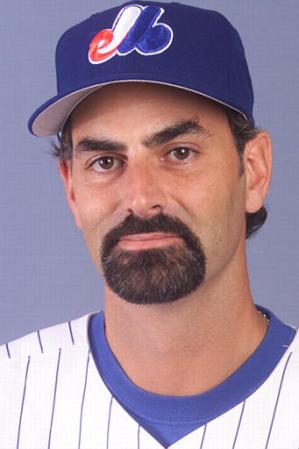

In [8]:
img

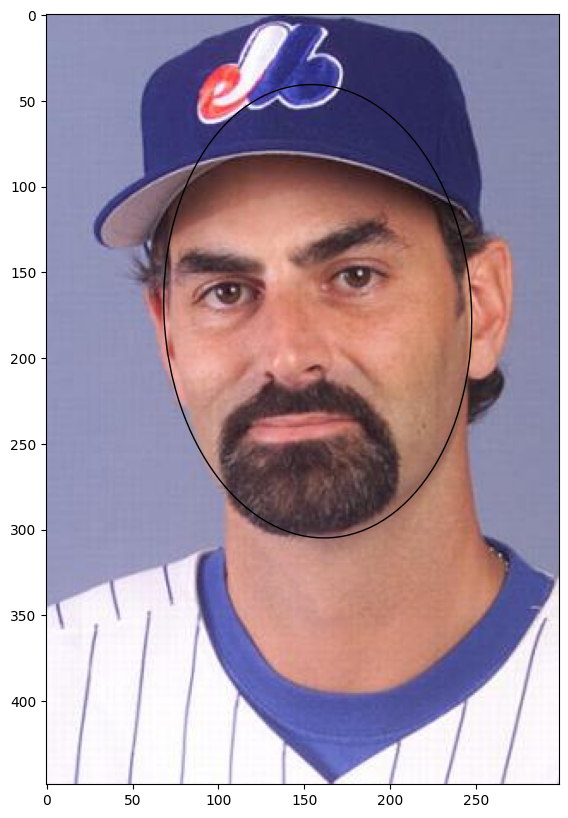

In [9]:
from matplotlib.collections import EllipseCollection

fig, ax = plt.subplots(figsize=(10, 10))
for ed in ellipse_dict[img_name]:
    major_axis_radius, minor_axis_radius, angle, center_x, center_y = ed

    ec = EllipseCollection(
        major_axis_radius * 2,
        minor_axis_radius * 2,
        np.degrees(angle),
        units="xy",
        offsets=(center_x, center_y),
        transOffset=ax.transData,
        facecolors="None",
    )
    ax.add_collection(ec)
ax.imshow(img, cmap="gray")

In [10]:
from ellipse_rcnn.utils.data.fddb import FDDB

ds = FDDB("../data/FDDB/", transform=lambda x: x)

In [11]:
image, target = ds[500]

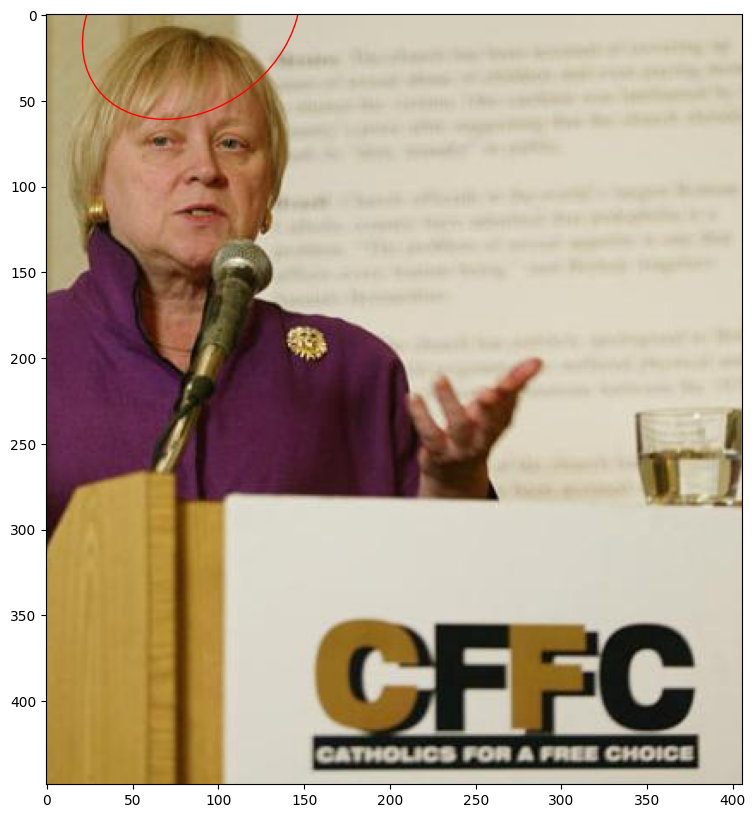

In [12]:
from ellipse_rcnn.utils.viz import plot_ellipses

fig, ax = plt.subplots(figsize=(10, 10))
plot_ellipses(target["ellipse_matrices"], ax=ax)
ax.imshow(image)

In [13]:
from ellipse_rcnn import EllipseRCNN

model = EllipseRCNN()

In [14]:
from ellipse_rcnn.utils.data.base import collate_fn

images, targets = collate_fn([(image, target)])

model.forward(images, targets)

ValueError: Batch size mismatch: A1 has shape torch.Size([]), A2 has shape torch.Size([1])

In [ ]:
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader
from ellipse_rcnn.core.model import EllipseRCNNLightning


dataset_loader = DataLoader(ds, batch_size=24, shuffle=True, collate_fn=collate_fn)

pl_model = EllipseRCNNLightning(model)
trainer = Trainer(max_epochs=10, accelerator="auto", log_every_n_steps=1)
trainer.fit(pl_model, dataset_loader)